In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Datamining/TextMining/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [14]:
!cp "/content/drive/My Drive/Datamining/TextMining/Notebooks/functions.py" .
import functions as f
import importlib
importlib.reload(f)
f.v()

2020-05-31 10:45


In [4]:
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from keras.initializers import Constant
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
import nltk
import io
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [6]:
df = f.loadSampleDataSetFromSpread(gc, 'https://docs.google.com/spreadsheets/d/1mE-QcKMxy70Xt5OoVb8s0GqjS7jQiBD12WzxtmcNQck/edit#gid=1204809874');
df

,text,is_spam,is_news,sentiment
0,@FinanceExaminer @michaeltg @TheBubbleBubble I...,False,0.0,1.0
1,China Authorities Probe Alleged Illegal Bitcoi...,False,1.0,-1.0
2,ALERT: Bitcoin Cash (BCH) at Euro 380.81 incre...,False,1.0,1.0
3,Pretty cool concept. 👍 $CHR #crypto #cryptocu...,True,NaN,NaN
4,"Crypto Market Hits $200 Billion, Bitcoin Ralli...",True,NaN,NaN
...,...,...,...,...
995,@CNBC @CNBCMakeIt He says if you make 70K a ye...,False,0.0,1.0
996,https://t.co/U6p7FgOdd8 via @BitcoinEcho,False,0.0,0.0
997,The last time BTC closed above 12k for the wee...,False,0.0,1.0
998,https://t.co/o5jXwqEdbn is for #sale!#domain #...,True,NaN,NaN


In [7]:
df_val = f.loadSampleDataSetFromSpread(gc, 'https://docs.google.com/spreadsheets/d/1G0sY49Ct5AU3OAV-kVU1SSJP9_-ci8N0aCvX00e2Gkg/edit#gid=2038236874')
df_val

,text,is_spam,is_news,sentiment
0,#BTC #Bitcoin to 7500$ and after this back to ...,False,0.0,1.0
1,@APompliano @McDonalds What is the cost of tra...,False,0.0,0.0
2,"Selling at 6,500USD. Bye Bitcoin Co. Ltd. htt...",False,0.0,-1.0
3,Lets play a game as we wait for Bakkt 10K BTC ...,False,0.0,1.0
4,@GoonAlerts_ Favorite coin @sentivate $SNTVT I...,False,0.0,1.0
...,...,...,...,...
495,#Blockchain #Crypto #Bitcoin #Ethereum #Tradin...,True,NaN,NaN
496,@CalvinAyre according to your mother bitcoin i...,False,0.0,1.0
497,Sold this put last week when bitcoin was above...,False,0.0,1.0
498,Block 598628 Hash: 0x...0df6063fdfd137f13322f9...,True,NaN,NaN


# Preparacion de datos para las RNN

In [0]:
x_dev_text = df['text'].apply(f.normalizeForTokenization)
y_dev = df['is_spam']
x_test_text = df_val['text'].apply(f.normalizeForTokenization)
y_test = df_val['is_spam']

In [0]:
vocab_size = 10000+1
embedding_dim = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
validation_size = 0.2

# Seteamos max_length teniendo en cuenta el largo promedio de los tweets
max_length = 50

In [0]:
x_train_text, x_validation_text, y_train, y_validation = train_test_split(x_dev_text, y_dev, test_size = validation_size, random_state=1234)

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train_text)
x_train = tokenizer.texts_to_sequences(x_train_text)
x_validation = tokenizer.texts_to_sequences(x_validation_text)
x_test = tokenizer.texts_to_sequences(x_test_text)

In [0]:
# Guardamos el tokenizador para poder usarlo después cuando agreguemos las columnas al dataset original (otra notebook)
with io.open(path + 'Modelos/' + 'tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())

In [0]:
x_train = pad_sequences(x_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_validation = pad_sequences(x_validation, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(x_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Naive Bayes

In [0]:
count_vect = CountVectorizer(tokenizer=word_tokenize, max_features=5000)
x_train_NB = count_vect.fit_transform(x_dev_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_NB = count_vect.transform(x_test_text) # cuenta frecuencia de tokens existentes en el diccionario

clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
NB_model = clf.fit(x_train_NB, y_dev)
pred = NB_model.predict(x_validation_NB)

In [16]:
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.758,
 'f1': 0.6702997275204359,
 'precision': 0.640625,
 'recall': 0.7028571428571428}

In [17]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[256,  69],
       [ 52, 123]], dtype=int32)>

Por las dudas pruebo NB validando contra "validación" (en lugar de test)

In [0]:
count_vect = CountVectorizer(tokenizer=word_tokenize, max_features=5000)
x_train_NB = count_vect.fit_transform(x_train_text) # cuenta frecuencia de tokens y define el diccionario
x_validation_NB = count_vect.transform(x_validation_text) # cuenta frecuencia de tokens existentes en el diccionario

clf = MultinomialNB(alpha=1) # alpha es el smoothing parameter
NB_model = clf.fit(x_train_NB, y_train)
pred = NB_model.predict(x_validation_NB)

In [19]:
{
    'f1' : f1_score(y_validation, pred),
    'accuracy': accuracy_score(y_validation, pred),
    'recall': recall_score(y_validation, pred),
    'precision': precision_score(y_validation, pred)
}

{'accuracy': 0.74,
 'f1': 0.6338028169014084,
 'precision': 0.5769230769230769,
 'recall': 0.703125}

# RNN

In [20]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           3000300   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,221,359
Trainable params: 3,221,359
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model_gru.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 90ms/step - loss: 0.6756 - accuracy: 0.6488 - val_loss: 0.6256 - val_accuracy: 0.6800
Epoch 2/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6469 - accuracy: 0.6488 - val_loss: 0.6154 - val_accuracy: 0.6800
Epoch 3/15
8/8 [==============================] - 0s 33ms/step - loss: 0.6060 - accuracy: 0.6837 - val_loss: 0.5536 - val_accuracy: 0.7550
Epoch 4/15
8/8 [==============================] - 0s 33ms/step - loss: 0.5048 - accuracy: 0.8000 - val_loss: 0.5505 - val_accuracy: 0.7350
Epoch 5/15
8/8 [==============================] - 0s 35ms/step - loss: 0.3949 - accuracy: 0.8562 - val_loss: 0.5887 - val_accuracy: 0.7650
Epoch 6/15
8/8 [==============================] - 0s 33ms/step - loss: 0.3784 - accuracy: 0.8825 - val_loss: 0.6477 - val_accuracy: 0.7100
Epoch 7/15
8/8 [==============================] - 0s 32ms/step - loss: 0.3926 - accuracy: 0.8575 - val_loss: 0.7738 - val_accuracy: 0.6400
Epoch 8/15
8/8 [===========

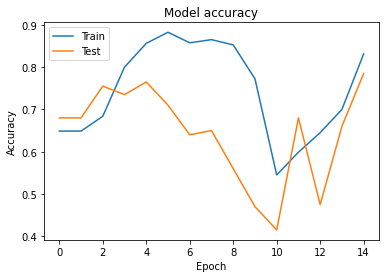

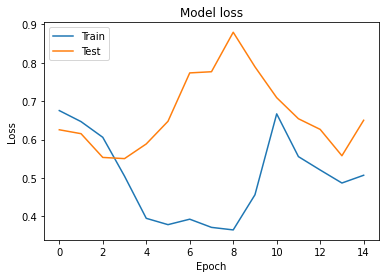

In [22]:
plot_history(history)

In [23]:
pred = model_gru.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.774,
 'f1': 0.6035087719298246,
 'precision': 0.7818181818181819,
 'recall': 0.49142857142857144}

In [25]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[301,  24],
       [ 89,  86]], dtype=int32)>

# RNN Bidireccional

In [26]:
model_bigru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bigru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bigru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [27]:
history = model_bigru.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 2s 198ms/step - loss: 0.6462 - accuracy: 0.6275 - val_loss: 0.5841 - val_accuracy: 0.6800
Epoch 2/15
8/8 [==============================] - 0s 49ms/step - loss: 0.5697 - accuracy: 0.7163 - val_loss: 0.5532 - val_accuracy: 0.7400
Epoch 3/15
8/8 [==============================] - 0s 48ms/step - loss: 0.4386 - accuracy: 0.8150 - val_loss: 0.5465 - val_accuracy: 0.7500
Epoch 4/15
8/8 [==============================] - 0s 51ms/step - loss: 0.3029 - accuracy: 0.8737 - val_loss: 0.4819 - val_accuracy: 0.7800
Epoch 5/15
8/8 [==============================] - 0s 51ms/step - loss: 0.1811 - accuracy: 0.9425 - val_loss: 0.7912 - val_accuracy: 0.7550
Epoch 6/15
8/8 [==============================] - 0s 52ms/step - loss: 0.1107 - accuracy: 0.9700 - val_loss: 0.5812 - val_accuracy: 0.8250
Epoch 7/15
8/8 [==============================] - 0s 51ms/step - loss: 0.0642 - accuracy: 0.9800 - val_loss: 0.8015 - val_accuracy: 0.7650
Epoch 8/15
8/8 [==========

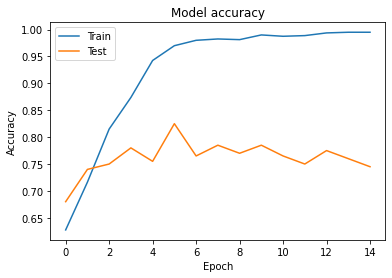

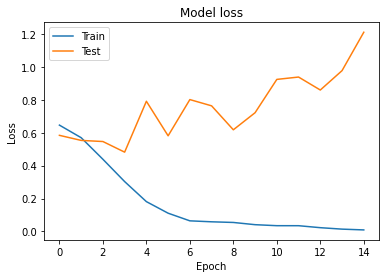

In [28]:
plot_history(history)

In [29]:
pred = model_bigru.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.762,
 'f1': 0.6628895184135979,
 'precision': 0.6573033707865169,
 'recall': 0.6685714285714286}

In [30]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[264,  61],
       [ 58, 117]], dtype=int32)>

# Embedding preentrenado

In [31]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

#load model
w2v_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

--2020-05-31 19:58:40--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.7MB/s    in 34s     

2020-05-31 19:59:15 (46.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# RNN con embedding preentrenado

In [32]:
model_gru_pre = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru_pre.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 3,221,359
Trainable params: 3,221,359
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model_gru_pre.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 81ms/step - loss: 0.6582 - accuracy: 0.6750 - val_loss: 0.5607 - val_accuracy: 0.7500
Epoch 2/15
8/8 [==============================] - 0s 33ms/step - loss: 0.5382 - accuracy: 0.7613 - val_loss: 0.5121 - val_accuracy: 0.7550
Epoch 3/15
8/8 [==============================] - 0s 33ms/step - loss: 0.4746 - accuracy: 0.7875 - val_loss: 0.5403 - val_accuracy: 0.6950
Epoch 4/15
8/8 [==============================] - 0s 32ms/step - loss: 0.4183 - accuracy: 0.8138 - val_loss: 0.5050 - val_accuracy: 0.7450
Epoch 5/15
8/8 [==============================] - 0s 32ms/step - loss: 0.3572 - accuracy: 0.8637 - val_loss: 0.5165 - val_accuracy: 0.7850
Epoch 6/15
8/8 [==============================] - 0s 31ms/step - loss: 0.3463 - accuracy: 0.8625 - val_loss: 0.4656 - val_accuracy: 0.7750
Epoch 7/15
8/8 [==============================] - 0s 33ms/step - loss: 0.2681 - accuracy: 0.9150 - val_loss: 0.5605 - val_accuracy: 0.8000
Epoch 8/15
8/8 [===========

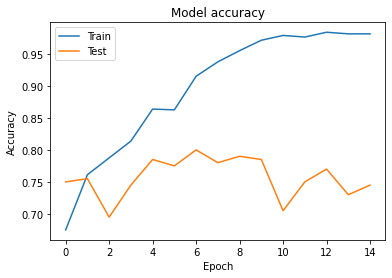

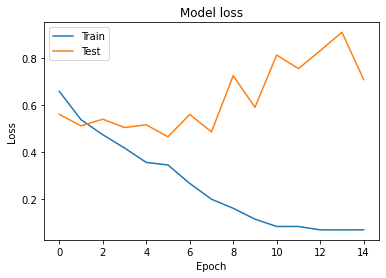

In [34]:
plot_history(history)

In [35]:
pred = model_gru_pre.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.784,
 'f1': 0.6931818181818182,
 'precision': 0.6892655367231638,
 'recall': 0.6971428571428572}

In [36]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[270,  55],
       [ 53, 122]], dtype=int32)>

In [0]:
# Dejo comentado el código para guardar y cargar
#modelFileName = 'gru_pre_2020-05-30_1355'
#modelFullPath = path + 'Modelos/' + modelFileName
#model_gru_pre.save(modelFullPath)
#new_model = tf.keras.models.load_model(modelFullPath)
#new_model.summary()

# RNN Bidireccional con embedding preentrenado

In [37]:
model_bigru_pre = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bigru_pre.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bigru_pre.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [38]:
history = model_bigru_pre.fit(x_train, y_train, batch_size=100, epochs=15, validation_data=(x_validation, y_validation))

Epoch 1/15
8/8 [==============================] - 1s 183ms/step - loss: 0.6752 - accuracy: 0.5688 - val_loss: 0.6421 - val_accuracy: 0.7450
Epoch 2/15
8/8 [==============================] - 0s 45ms/step - loss: 0.5886 - accuracy: 0.7563 - val_loss: 0.5449 - val_accuracy: 0.7300
Epoch 3/15
8/8 [==============================] - 0s 47ms/step - loss: 0.5084 - accuracy: 0.7650 - val_loss: 0.4817 - val_accuracy: 0.7900
Epoch 4/15
8/8 [==============================] - 0s 48ms/step - loss: 0.4325 - accuracy: 0.8250 - val_loss: 0.5557 - val_accuracy: 0.7500
Epoch 5/15
8/8 [==============================] - 0s 47ms/step - loss: 0.3933 - accuracy: 0.8325 - val_loss: 0.5585 - val_accuracy: 0.7250
Epoch 6/15
8/8 [==============================] - 0s 46ms/step - loss: 0.3288 - accuracy: 0.8600 - val_loss: 0.4358 - val_accuracy: 0.8050
Epoch 7/15
8/8 [==============================] - 0s 48ms/step - loss: 0.2649 - accuracy: 0.8963 - val_loss: 0.4860 - val_accuracy: 0.8050
Epoch 8/15
8/8 [==========

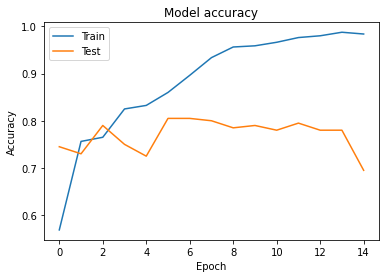

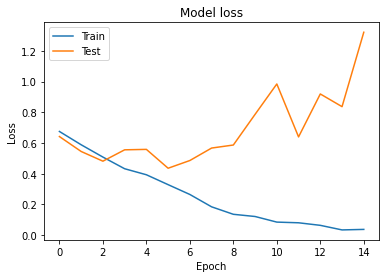

In [39]:
plot_history(history)

In [40]:
pred = model_bigru_pre.predict(x_test)
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.708,
 'f1': 0.663594470046083,
 'precision': 0.555984555984556,
 'recall': 0.8228571428571428}

In [41]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[210, 115],
       [ 31, 144]], dtype=int32)>

# RNN (también bidireccional) con embedding preentrenado y 5-fold cross validation

In [0]:
model_gru_pre_5fold = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru_pre_5fold.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru_pre_5fold.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
gru_6 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 3,166,831
Trainable params: 3,166,831
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_bigru_pre_5fold = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_bigru_pre_5fold.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bigru_pre_5fold.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 256)           330240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [0]:
tokenizer_cv = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_cv.fit_on_texts(x_dev_text)
x_dev_cv = tokenizer_cv.texts_to_sequences(x_dev_text)
x_test_cv = tokenizer_cv.texts_to_sequences(x_test_text)

In [0]:
x_dev_cv = pad_sequences(x_dev_cv, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_test_cv = pad_sequences(x_test_cv, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
kf = KFold(5, shuffle = True, random_state=1234)
for train_cv, test_cv in kf.split(x_dev_cv):
    # Entreno las 2 redes simultaneamente :)
    model_gru_pre_5fold.fit(
        x_dev_cv[train_cv], y_dev[train_cv],
        batch_size=100, epochs=10,
        validation_data=(x_dev_cv[test_cv], y_dev[test_cv]))
    model_bigru_pre_5fold.fit(
        x_dev_cv[train_cv], y_dev[train_cv],
        batch_size=100, epochs=10,
        validation_data=(x_dev_cv[test_cv], y_dev[test_cv]))

Epoch 1/10
8/8 [==============================] - 1s 69ms/step - loss: 0.6787 - accuracy: 0.6475 - val_loss: 0.6522 - val_accuracy: 0.6800
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6435 - accuracy: 0.6488 - val_loss: 0.6311 - val_accuracy: 0.6800
Epoch 3/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6444 - accuracy: 0.6488 - val_loss: 0.6290 - val_accuracy: 0.6800
Epoch 4/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6343 - accuracy: 0.6488 - val_loss: 0.6213 - val_accuracy: 0.6800
Epoch 5/10
8/8 [==============================] - 0s 32ms/step - loss: 0.6072 - accuracy: 0.6500 - val_loss: 0.5807 - val_accuracy: 0.7100
Epoch 6/10
8/8 [==============================] - 0s 34ms/step - loss: 0.5398 - accuracy: 0.7325 - val_loss: 0.5523 - val_accuracy: 0.6950
Epoch 7/10
8/8 [==============================] - 0s 34ms/step - loss: 0.4830 - accuracy: 0.7713 - val_loss: 0.5122 - val_accuracy: 0.7400
Epoch 8/10
8/8 [===========

In [0]:
pred = model_gru_pre_5fold.predict(x_test_cv) 
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.756,
 'f1': 0.61875,
 'precision': 0.6827586206896552,
 'recall': 0.5657142857142857}

In [0]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[279,  46],
       [ 76,  99]], dtype=int32)>

In [0]:
pred = model_bigru_pre_5fold.predict(x_test_cv) 
pred = pred[:,0] > 0.5
{
    'f1' : f1_score(y_test, pred),
    'accuracy': accuracy_score(y_test, pred),
    'recall': recall_score(y_test, pred),
    'precision': precision_score(y_test, pred)
}

{'accuracy': 0.752,
 'f1': 0.6457142857142857,
 'precision': 0.6457142857142857,
 'recall': 0.6457142857142857}

In [0]:
tf.math.confusion_matrix(labels=y_test, predictions=pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[263,  62],
       [ 62, 113]], dtype=int32)>

In [0]:
# Guardo el modelo que dio mejor hasta ahora
modelFileName = 'spam_bigru_pre_2020-05-30_0000'
#modelFullPath = path + 'Modelos/' + modelFileName
#model_bigru_pre.save(modelFullPath)
#new_model = tf.keras.models.load_model(modelFullPath)
#new_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Datamining/TextMining/Modelos/spam_bigru_pre_2020-05-30_2120/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           3000300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           330240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
____________________________________________